In [1]:
import numpy as np
import scipy as sp
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import random 
from math import ceil, log10
from sklearn.preprocessing import normalize  

import os
import subprocess

In [ ]:
# for i in range(50): 
#     print('\\node[vertex] (v' + str(i) + ') at (' + str(random.random())  + '*\lw, ' + str(random.random()) +'*\lh) {' + str(i) +'};')  

In [2]:
data = np.zeros([50,2])
for i in range(50):
    data[i,0] = random.random()
    data[i,1] = random.random()

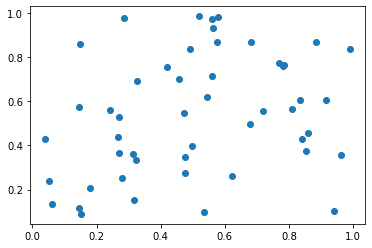

In [3]:
plt.plot(data[:,0], data[:,1], 'o')

In [12]:
np.savetxt('data.csv', data)

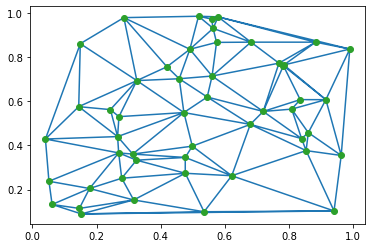

In [4]:
tri = Delaunay(data, qhull_options='QJ')
plt.triplot(data[:,0], data[:,1], tri.simplices.copy())
plt.plot(data[:,0], data[:,1], 'o')

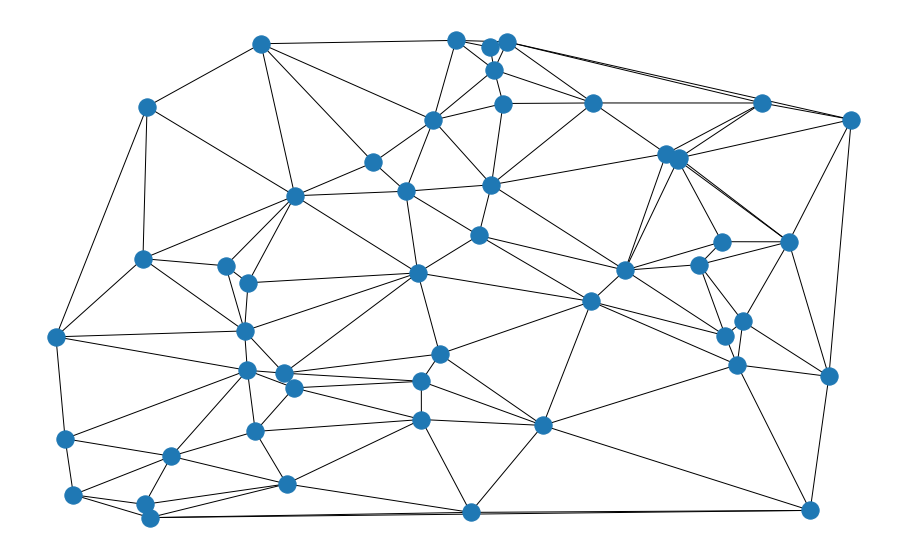

In [15]:
fig = plt.figure(figsize=[16,10])
ax = fig.add_subplot()

# create a set for edges that are indexes of the points
edges = set()
# for each Delaunay triangle
for n in range(tri.nsimplex):
    # for each edge of the triangle
    # sort the vertices
    # (sorting avoids duplicated edges being added to the set)
    # and add to the edges set
    edge = sorted([tri.vertices[n,0], tri.vertices[n,1]])
    edges.add((edge[0], edge[1]))
    edge = sorted([tri.vertices[n,0], tri.vertices[n,2]])
    edges.add((edge[0], edge[1]))
    edge = sorted([tri.vertices[n,1], tri.vertices[n,2]])
    edges.add((edge[0], edge[1]))


# make a graph based on the Delaunay triangulation edges
graph = nx.Graph()
graph.add_nodes_from(range(data.shape[0]))
graph.add_edges_from(edges)
nx.set_node_attributes(graph, name='predicate', values='x')
nx.set_edge_attributes(graph, name='dummy', values='y')


# plot graph
pointIDXY = dict(zip(range(len(data)), data))
nx.draw(graph, pointIDXY, ax=ax)
plt.axis('off')
plt.show()
plt.close(fig)

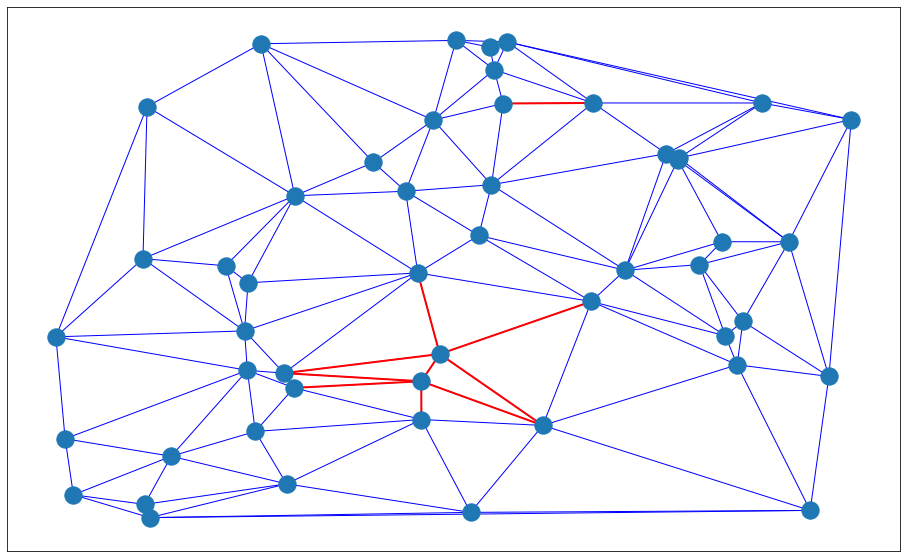

In [6]:
fig = plt.figure(figsize=[16,10])
ax = fig.add_subplot()
nx.draw_networkx_edges(graph, pointIDXY, edgelist=[e for e in graph.edges], edge_color='b', ax=ax)
nx.draw_networkx_edges(graph, pointIDXY, edgelist=[e for e in graph.edges][:10], edge_color='r', width=2, ax=ax)
nx.draw_networkx_nodes(graph, pointIDXY, ax=ax)
plt.show()
plt.close(fig)

In [9]:
graph.get_edge_data?

In [42]:
import random


def hops(P, D, u=None, vertex_label='predicate', edge_label='dummy', init_labels=True):
    '''Convenience method to call HOPS. You may specify the edge and vertex labels that should be considered.
    Currently, both edge and vertex attributes must exist. If you want to compare unlabeled graphs, create a 
    constant label attribute for your edges and/or vertices.'''
    
    if u is None:
        u = 0

    # sample first image of u
    n = len(D.nodes)
    vi = random.randrange(n)
    v = vi

    c, phi, phi_inv, traversallist = find_tree_embeddings(u, v, {u: v}, {v: u}, P, D, list(), vertex_label=vertex_label, edge_label=edge_label)
    c *= n

    return c, phi, phi_inv, traversallist


def find_tree_embeddings(u, v, phi, phi_inv, H, G, traversallist, vertex_label, edge_label):
    '''u,v must be integer indices that are used to access nodes in H and G.
    phi and phi inverse give the mapping from H to G and from G to H and should
    be initialized to {u: v} and {v: u} if you call it for a initial node pair.
    See the convenience method hops().
    traversallist should be initialized to the empty list and gives you information 
    on the iterations of the method as dicts.'''
    
    U_n = list()
    V_n = list()
    for u_neigh in H.neighbors(u):
        if u_neigh not in phi.keys():
            H.nodes[u_neigh]['hops_predicate'] = (H.nodes[u_neigh][vertex_label], H.get_edge_data(u, u_neigh)[edge_label])
            U_n.append(u_neigh)
    for v_neigh in G.neighbors(v):
        if v_neigh not in phi_inv.keys():
            G.nodes[v_neigh]['hops_predicate'] = (G.nodes[v_neigh][vertex_label], G.get_edge_data(v, v_neigh)[edge_label])
            V_n.append(v_neigh)
    
    # visualization data
    viz = dict()
    viz['u'] = u
    viz['v'] = v
    viz['U_n'] = U_n
    viz['V_n'] = V_n
    viz['ext'] = list()
    traversallist.append(viz)
    
    M, c = uniformRandomMaximumMatching(U_n, V_n, H, G)
    if len(M) == len(U_n):
        # add matching to phi
        for x in M.keys():
            y = M[x]
            phi[x] = y
            phi_inv[y] = x     
            viz['ext'].append((v,y))
            
        viz['phi'] = phi.copy()
        viz['phi_inv'] = phi_inv.copy()
        
        # recurse
        for x in M.keys():
            c_rec, phi, phi_inv, traversallist = find_tree_embeddings(x, M[x], phi, phi_inv, H, G, traversallist, vertex_label, edge_label)
            c *= c_rec
            if c == 0:
                break
    else:
        c = 0

    return c, phi, phi_inv, traversallist

def n_max_matchings(A, B):
    """
    Compute the number of maximum matchings in a complete bipartite graph on A + B vertices.
    A and B are required to be nonnegative.
    Corner Case: If at least one of the sides has zero vertices, there is one maximal matching: the empty set.
    """
    a = min(A, B)
    b = max(A, B)
    c = 1

    if a != 0:
        for i in range(b - a + 1, b + 1):
            c *= i

    return c


def uniformRandomMaximumMatching(N_u, N_v, H, G):
    """
    Draw a maximum matching from a block disjoint bipartite graph uniformly at random and return it and
    the number of such matchings.

    Which vertex x can be assigned to which vertex y is given by x['predicate'] == y['predicate']

    :param N_u: list of vertices from H that must be assigned
    :param N_v: list of vertices from G that can be assigned to
    :return: M, c : a matching M, given as a map and the number of all maximum matchings c
    """

    hu = dict()
    hv = dict()
    c = 1

    # create blocks of identical symbols
    for x in N_u:
        try:
            hu[H.nodes[x]['hops_predicate']].append(x)
        except KeyError:
            hu[H.nodes[x]['hops_predicate']] = [x]

    for y in N_v:
        try:
            hv[G.nodes[y]['hops_predicate']].append(y)
        except KeyError:
            hv[G.nodes[y]['hops_predicate']] = [y]

    # shuffle target list
    for y in hv.keys():
        random.shuffle(hv[y])

    # compute uniform random maximal matching
    matching = dict()
    for x in hu.keys():
        try:
            for i, j in zip(hu[x], hv[x]):
                matching[i] = j
            c *= n_max_matchings(len(hu[x]), len(hv[x]))
        except KeyError:
            pass
    return matching, c





# # taken from sampler_general_ex.py
# # assumptions that I am now making:
# # - predicate is a categorical label (and used in the same way we use labels)
# # - there are no edge labels (they seem to be represented by intermediary 'label vertices' e.g. 'predicate=interaction'
# # - if there is a 'valueinpattern' this is an additional restriction and this breaks our assumptions.
# #   hence, we will remove this feature from the system for comparison purposes
# def predicate_match(x, y):
#     if x['predicate'] == y['predicate']:
#         if y['valueinpattern'] == 1:
#             if 'value' in x.keys() and x['value'] == y['value']:
#                 return True
#             else:
#                 return False
#         else:
#             return True
#     else:
#         return False


# # taken from sampler_general_ex.py
# def matches(n, D, m, P, matched_list, Plist):
#     """
#     n - node from dataset graph D to match with node m from pattern P
#     matched_list - already matched nodes from D
#     Plist - list of node IDs from P, which gives the ordering of finding the pattern
#     """
#     if predicate_match(D.node[n], P.node[m]):
#         test_list = matched_list + [n]
#         neighbor_test = True
#         for m_neigh in P.neighbors(m):
#             index_in_Plist = Plist.index(m_neigh)
#             if index_in_Plist < len(test_list):
#                 image = test_list[index_in_Plist]  # this is m_neigh's corresponding image in D
#                 if image not in D.neighbors(n):
#                     neighbor_test = False
#         return neighbor_test
#     else:
#         return False

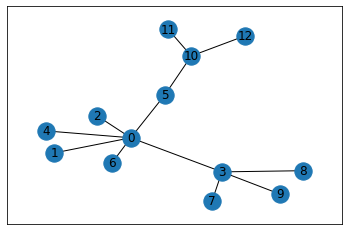

In [43]:
# create pattern graph
star = nx.star_graph(6)
star.add_edges_from([(3,7), (3,8), (3,9), (5,10), (10,11), (10,12)])
nx.set_node_attributes(star, name='predicate', values='x')
nx.set_edge_attributes(star, name='dummy', values='y')
starIDXY = nx.spring_layout(star, scale=0.3, center=(-0.5, 0.5))
nx.draw_networkx(star, pos=starIDXY)

In [51]:
# run the hops algorithm
c, phi, phi_i, viz = hops(P=star, D=graph, vertex_label='predicate', edge_label='dummy')
print(c, phi, phi_i, viz)

10368000 {0: 23, 1: 0, 2: 1, 3: 48, 4: 35, 5: 44, 6: 10, 7: 39, 8: 9, 9: 30, 10: 40, 11: 4, 12: 46} {23: 0, 0: 1, 1: 2, 48: 3, 35: 4, 44: 5, 10: 6, 39: 7, 9: 8, 30: 9, 40: 10, 4: 11, 46: 12} [{'u': 0, 'v': 23, 'U_n': [1, 2, 3, 4, 5, 6], 'V_n': [0, 1, 35, 44, 10, 48], 'ext': [(23, 0), (23, 1), (23, 48), (23, 35), (23, 44), (23, 10)], 'phi': {0: 23, 1: 0, 2: 1, 3: 48, 4: 35, 5: 44, 6: 10}, 'phi_inv': {23: 0, 0: 1, 1: 2, 48: 3, 35: 4, 44: 5, 10: 6}}, {'u': 1, 'v': 0, 'U_n': [], 'V_n': [29, 4], 'ext': [], 'phi': {0: 23, 1: 0, 2: 1, 3: 48, 4: 35, 5: 44, 6: 10}, 'phi_inv': {23: 0, 0: 1, 1: 2, 48: 3, 35: 4, 44: 5, 10: 6}}, {'u': 2, 'v': 1, 'U_n': [], 'V_n': [49, 29], 'ext': [], 'phi': {0: 23, 1: 0, 2: 1, 3: 48, 4: 35, 5: 44, 6: 10}, 'phi_inv': {23: 0, 0: 1, 1: 2, 48: 3, 35: 4, 44: 5, 10: 6}}, {'u': 3, 'v': 48, 'U_n': [7, 8, 9], 'V_n': [8, 30, 9, 39], 'ext': [(48, 39), (48, 9), (48, 30)], 'phi': {0: 23, 1: 0, 2: 1, 3: 48, 4: 35, 5: 44, 6: 10, 7: 39, 8: 9, 9: 30}, 'phi_inv': {23: 0, 0: 1, 1: 2,

In [197]:
viz[0]['old_phi_inv'] = dict()
viz[0]['old_edges'] = list()
viz[0]['old_edges_pattern'] = list()
for i in range(1,len(viz)):
    viz[i]['old_phi_inv'] = viz[i-1]['phi_inv']
    viz[i]['old_edges'] = viz[i-1]['old_edges'] + viz[i-1]['ext']
    viz[i]['old_edges_pattern'] = viz[i-1]['old_edges_pattern'] + [(viz[i]['phi_inv'][e[0]], viz[i]['phi_inv'][e[1]]) for e in viz[i-1]['ext']]

{0: array([-0.35046098,  0.14953902]), 1: array([-0.21948563,  0.28051437]), 2: array([-0.08058389,  0.41941611]), 3: array([-0.79119046,  0.29119046]), 4: array([-0.33824516,  0.16175484]), 5: array([-0.28602487,  0.78602487]), 6: array([-0.50918564,  0.00918564]), 7: array([-0.83244044,  0.33244044]), 8: array([-0.74669647,  0.24669647]), 9: array([-0.92825715,  0.42825715]), 10: array([-0.33838071,  0.83838071]), 11: array([-0.39586961,  0.89586961]), 12: array([-0.30957095,  0.80957095])}


In [223]:
def show_active(graph, pointIDXY, pattern, patternIDXY, i, viz, format_positions, show=False, pic_id=None):
    
    # Active vertex
    fig = plt.figure(figsize=[16,10])
    ax = fig.add_subplot()
    
    # pattern
    nx.draw_networkx_edges(pattern, pos=patternIDXY,
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(pattern, patternIDXY, 
                           edgelist=viz[i]['old_edges_pattern'], 
                           edge_color='blue', ax=ax)
    
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=viz[i]['old_phi_inv'].values(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=[viz[i]['u']], node_color='r',
                           ax=ax)
    
    
    # graph
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=[e for e in graph.edges], 
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=viz[i]['old_edges'], 
                           edge_color='blue', ax=ax)
    
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=viz[i]['old_phi_inv'].keys(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=[viz[i]['v']], node_color='r',
                           ax=ax)
    
    if pic_id is None:
        plt.savefig(os.path.join(data_path, f'{i:0{format_positions}d}_1.png'))
    else:
        plt.savefig(os.path.join(data_path, f'vv{pic_id:0{format_positions}d}.png'))
    if show:
        plt.show()
    plt.close(fig)
    
    
def show_candidates(graph, pointIDXY, pattern, patternIDXY, i, viz, format_positions, show=False, pic_id=None):
    # Matching Candidates
    fig = plt.figure(figsize=[16,10])
    ax = fig.add_subplot()
    
    
    # pattern
    nx.draw_networkx_edges(pattern, pos=patternIDXY,
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(pattern, patternIDXY, 
                           edgelist=viz[i]['old_edges_pattern'], 
                           edge_color='blue', ax=ax)
    
    
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=viz[i]['old_phi_inv'].values(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=[viz[i]['u']], node_color='r',
                           ax=ax)
    nx.draw_networkx_edges(pattern, patternIDXY, 
                           edgelist=[(viz[i]['u'], w) for w in viz[i]['U_n']], 
                           edge_color='yellow', width=3, ax=ax)
    
    
    # graph
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=[e for e in graph.edges], 
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=viz[i]['old_edges'], 
                           edge_color='blue', ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=[(viz[i]['v'], w) for w in viz[i]['V_n']], 
                           edge_color='yellow', width=3, ax=ax)
    
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=viz[i]['old_phi_inv'].keys(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=[viz[i]['v']], node_color='r',
                           ax=ax)
    
    if pic_id is None:
        plt.savefig(os.path.join(data_path, f'{i:0{format_positions}d}_2.png'))
    else:
        plt.savefig(os.path.join(data_path, f'vv{pic_id:0{format_positions}d}.png'))
    if show:
        plt.show()
    plt.close(fig)
    
    
def show_matching(graph, pointIDXY, pattern, patternIDXY, i, viz, format_positions, show=False, pic_id=None):
    # Selected matching
    fig = plt.figure(figsize=[16,10])
    ax = fig.add_subplot()   
    
    
    # pattern
    nx.draw_networkx_edges(pattern, pos=patternIDXY,
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(pattern, patternIDXY, 
                           edgelist=viz[i]['old_edges_pattern'], 
                           edge_color='blue', ax=ax)
    
    
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=viz[i]['old_phi_inv'].values(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=viz[i]['phi_inv'].values(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(pattern, patternIDXY, 
                           nodelist=[viz[i]['u']], node_color='r',
                           ax=ax)
    nx.draw_networkx_edges(pattern, patternIDXY, 
                           edgelist=[(viz[i]['u'], w) for w in viz[i]['U_n']], 
                           edge_color='red', width=3, ax=ax)
    
    
    # graph
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=[e for e in graph.edges], 
                           edge_color='gray', ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=viz[i]['old_edges'], 
                           edge_color='blue', ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=[(viz[i]['v'], w) for w in viz[i]['V_n']], 
                           edge_color='yellow', width=3, ax=ax)
    nx.draw_networkx_edges(graph, pointIDXY, 
                           edgelist=viz[i]['ext'], 
                           edge_color='red', width=4, ax=ax)
    
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           node_color='gray', ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=viz[i]['old_phi_inv'].keys(), node_color='blue',
                           ax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=viz[i]['phi_inv'].keys(), node_color='blue',
                           cax=ax)
    nx.draw_networkx_nodes(graph, pointIDXY, 
                           nodelist=[viz[i]['v']], node_color='r',
                           ax=ax)

    if pic_id is None:
        plt.savefig(os.path.join(data_path, f'{i:0{format_positions}d}_3.png'))
    else:
        plt.savefig(os.path.join(data_path, f'vv{pic_id:0{format_positions}d}.png'))
    if show:
        plt.show()
    plt.close(fig)

In [224]:
data_path = './'

nstarIDXY = starIDXY #normalizepos(starIDXY, norm='l2', size=0.3)


# compute right number of trailing zeros for file names
j = 0
format_positions = ceil(log10(3 * len(viz)))

for i in range(len(viz)):

    show_active(graph, pointIDXY, star, nstarIDXY, i, viz, format_positions, pic_id=j)   
    show_candidates(graph, pointIDXY, star, nstarIDXY, i, viz, format_positions, pic_id=j+1)
    show_matching(graph, pointIDXY, star, nstarIDXY, i, viz, format_positions,pic_id=j+2)
    j += 3

In [226]:
outfile = 'video.mp4'
stuff = subprocess.run(['ffmpeg', '-r', '1', '-f', 'image2', '-s', '1152x720', '-i', f'vv%0{format_positions}d.png', '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', outfile])
print(stuff)

CompletedProcess(args=['ffmpeg', '-r', '1', '-f', 'image2', '-s', '1152x720', '-i', 'vv%02d.png', '-vcodec', 'libx264', '-crf', '25', '-pix_fmt', 'yuv420p', 'video.mp4'], returncode=1)
